In [7]:
import sys
from pathlib import Path
project_root = Path.cwd().parent
sys.path.append(str(project_root))
from visualization.utils import defaultColors
from helpers import load_from_path, save_pdf

In [8]:
# from mobo.surrogate_model import BoTorchSurrogateModelReapeat, BoTorchSurrogateModel
import pandas as pd
from pathlib import Path
import numpy as np
import yaml

In [9]:
# qnehvi, raqnehvi, mars
# path_list = list(Path("../good results/peaks/risk-averse1/mars/").glob("*"))
# path_list = list(Path("../good results/peaks/risk-averse1/raqnehvi/").glob("*"))
# path_list = list(Path("../good results/peaks/risk-averse1/qnehvi/").glob("*"))

path_dict = {
    "qnehvi": list(Path("../good results/peaks/risk-averse1/qnehvi/").glob("*")),
    "raqnehvi": list(Path("../good results/peaks/risk-averse1/raqnehvi/").glob("*")),
    "mars": list(Path("../good results/peaks/risk-averse1/mars/").glob("*")),
}
path = path_dict["qnehvi"][0]

res_dict = load_from_path(path)
eval_sample = res_dict["eval_samples"]
batch_size = res_dict["batch_size"]
init_samples = res_dict["init_samples"]

index = eval_sample.index + 1

hv_dict = {}

for algo, path_list in path_dict.items():
        
    #load all evaluated samples from path_list and create one big dataframe with columnnames appended with ___i
    eval_samples = pd.concat([load_from_path(path)["eval_samples"] for path in path_list], keys=range(len(path_list)), names=["seed"])
    eval_samples = eval_samples.reset_index()

    #check if all same length
    if len(eval_samples.groupby("seed").size().unique()) != 1:
        raise ValueError("Not all seeds have the same number of iterations")

    eval_samples_mean = eval_samples.groupby("iterID").transform("mean").iloc[eval_sample.index]
    eval_samples_std = eval_samples.groupby("iterID").transform("std").iloc[eval_sample.index]
    hv_mean = eval_samples_mean["Hypervolume_indicator"]
    hv_std = eval_samples_std["Hypervolume_indicator"]
    
    hv_dict[algo] = {
        "mean": hv_mean,
        "std": hv_std,
    }


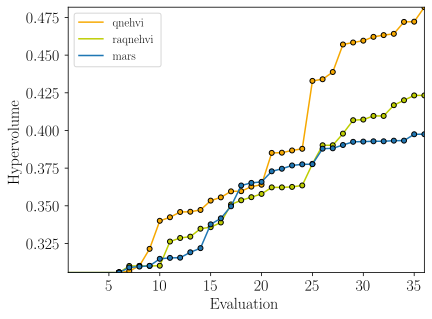

In [10]:
%config InlineBackend.figure_format='svg'
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Helvetica"],
    # font size
    "font.size": 16,
})

colors = defaultColors

batch_dots = eval_sample["iterID"]*batch_size +init_samples

fig, ax = plt.figure(), plt.gca()

i = 0
for algo, hv in hv_dict.items():
    mean = hv["mean"]
    std = hv["std"]
    ax.plot(index, mean, label=algo, color=colors[i], linestyle="-")
    ax.plot(batch_dots, mean, color=colors[i], marker="o", linestyle="None", markersize=5, 
            markeredgecolor="black")
    # ax.fill_between(index, mean - std, mean + std, color=colors[i], alpha=0.3, edgecolor=colors[i], linewidth=2.)
    i += 2

ax.set_xlabel("Evaluation")
ax.set_ylabel("Hypervolume")
#log scale
# ax.set_yscale("log")
# ax.set_title("Hypervolume and MVaR Hypervolume")
ax.set_ylim(min([hv["mean"].min() for hv in hv_dict.values()]), max([hv["mean"].max() for hv in hv_dict.values()]))
ax.set_xlim(1, index.max())
ax.legend(fontsize=12, loc="upper left")

save_pdf(fig, path, "hv_comparison")
